# MSc Data Science Dissertation

## Geospatial Matching of TfL Stations

#### Name: Chandana Karunaratne
#### Student ID: 1621633
#### Date: 24 August 2017

In [21]:
# The code below is used to match each TfL station with its respective Supergroup label based on the station's geographic 
# coordinates.

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import fiona 
import shapely.geometry
from shapely.geometry import Point, shape
import geopandas as gpd
import pylab
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pyproj



In [27]:
# Read in the input files

stationdic_df = pd.read_csv("StationsDictionary_CK4.csv")     # Read in a file containing the keys and the corresponding names of all the stations and stops in the TfL dataset (including TfL tube stations, bus stops, and tram stations)
stationlist_df = pd.read_csv("TfL_Stations.csv")      # Read in a file containing the names of only unique TfL tube stations


In [28]:
# Create a new column in stationdic_df called 'Keep' and set the default value as 'False'. This is to be used to determine which
# stations in the TfL dataset refer to tube stations and will be used to filter out journeys taken on buses, trams, and other non-tube and non-rail services.

stationdic_df['Keep'] = 'False'

In [ ]:
# Match each station in stationdic_df with the actual list of tube and rail stations in stationlist_df (so that I can later delete the stations in stationdic_df that are not tube and rail stations)

count = 0
true_count = 0

while (count < len(stationdic_df)):
    list_count = 0
    while (list_count < len(stationlist_df) and (stationdic_df['Keep'][count] != 'True')):
        if stationdic_df['STATIONNAME'][count] == stationlist_df['Station'][list_count]:
            stationdic_df['Keep'][count] = 'True'
            true_count = true_count + 1
        list_count = list_count + 1
    count = count + 1
 

In [5]:
# Delete all rows where 'Keep' = 'False' (essentially, I'm only keeping those stations which were matched up with the actual list of tube and rail stations)

stationdic_df = stationdic_df[stationdic_df.Keep != 'False']

In [8]:
stationdic_df.head()

,STATIONKEY,STATIONNAME,Keep
2,1,Acton Town,True
3,2,Barbican,True
4,3,Aldgate,True
5,4,Aldgate East,True
6,5,Alperton,True


In [7]:
# Re-start the numbering of the index for stationdic_df (without creating a new column for it)

stationdic_df = stationdic_df.reset_index(drop=True)

In [8]:
stationdic_df.head()

,STATIONKEY,STATIONNAME,Keep
0,1,Acton Town,True
1,2,Barbican,True
2,3,Aldgate,True
3,4,Aldgate East,True
4,5,Alperton,True


In [9]:
# Create a new column called 'Supergroup' in stationdic_df and set the default value to 0.

stationdic_df['Supergroup'] = 0

In [12]:
# Add the string 'Station, London' to the end of each station name so that it is more easily searcheable using the geopandas library.

stationdic_df['STATIONNAME'] = stationdic_df['STATIONNAME'].astype(str) + ' Station, England'

In [13]:
stationdic_df.head()

,STATIONKEY,STATIONNAME,Keep,Supergroup
0,1,"Acton Town Station, England",True,0
1,2,"Barbican Station, England",True,0
2,3,"Aldgate Station, England",True,0
3,4,"Aldgate East Station, England",True,0
4,5,"Alperton Station, England",True,0


In [18]:
# Read in the LOAC shapefile using geopandas to enable the creation of a visualization of the output areas in the LOAC dataset.

loac_map = gpd.read_file("Shapefiles/LOAC_London.shp")

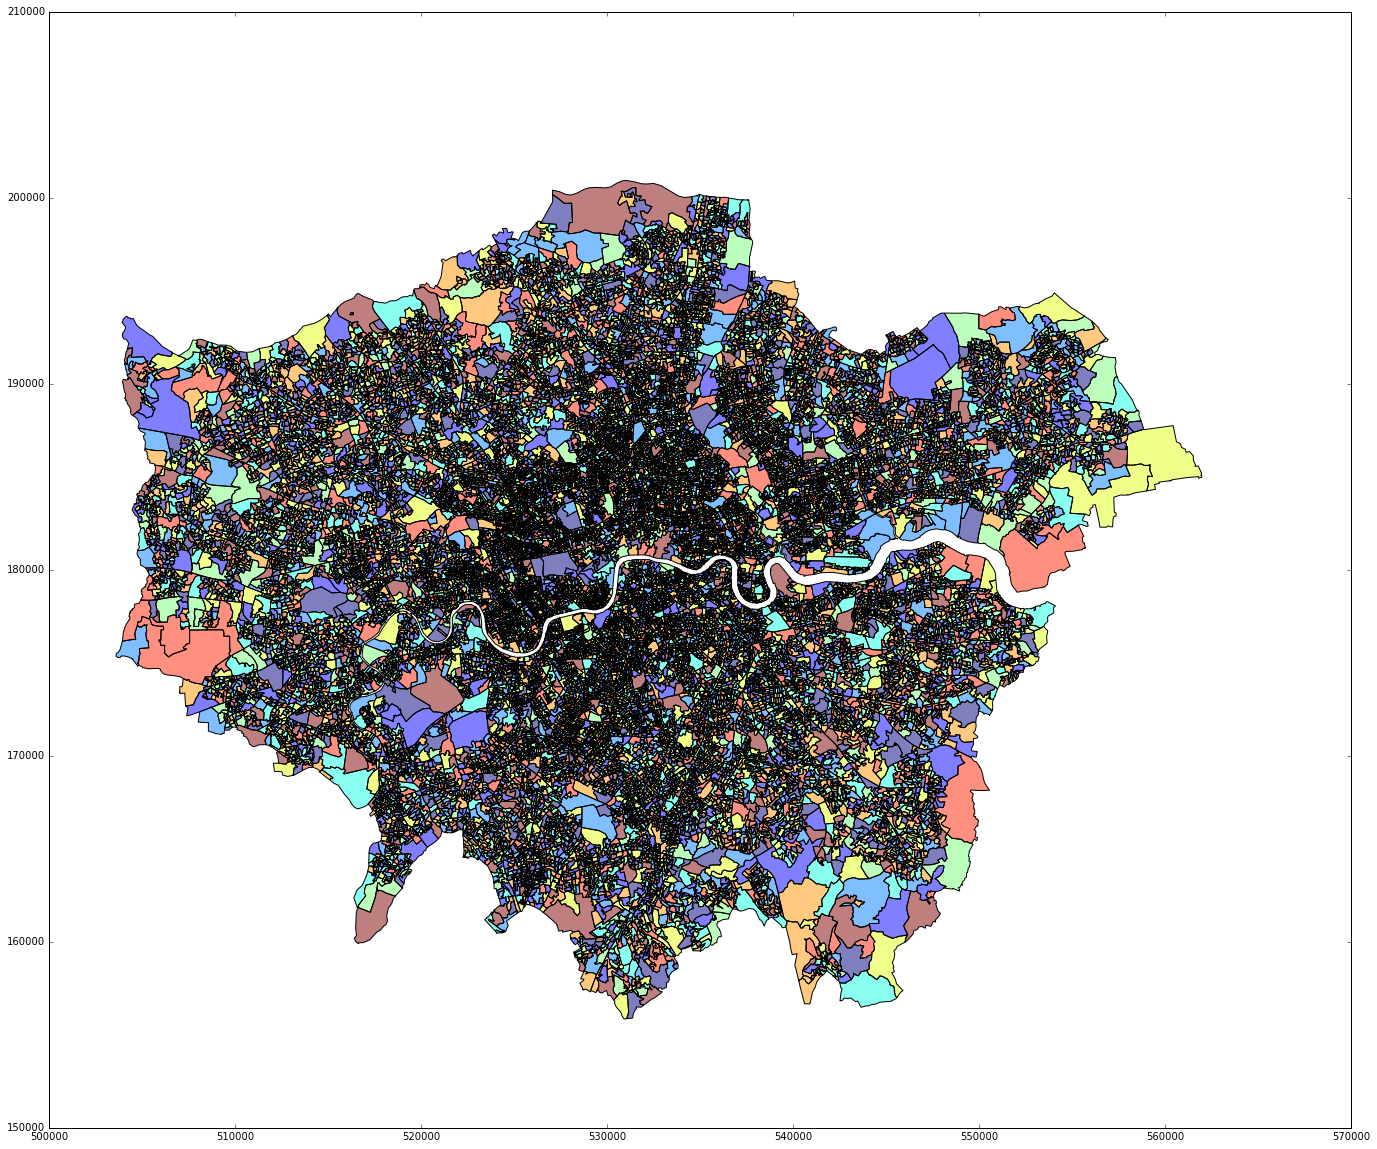

In [19]:
# Create a visualization of the 25,000 output areas in Greater London.

loac_map.plot(figsize=(30,20))


In [ ]:
# Save the above visualization to an output file

pylab.savefig("LOAC_Overview")   


(180000, 185000)

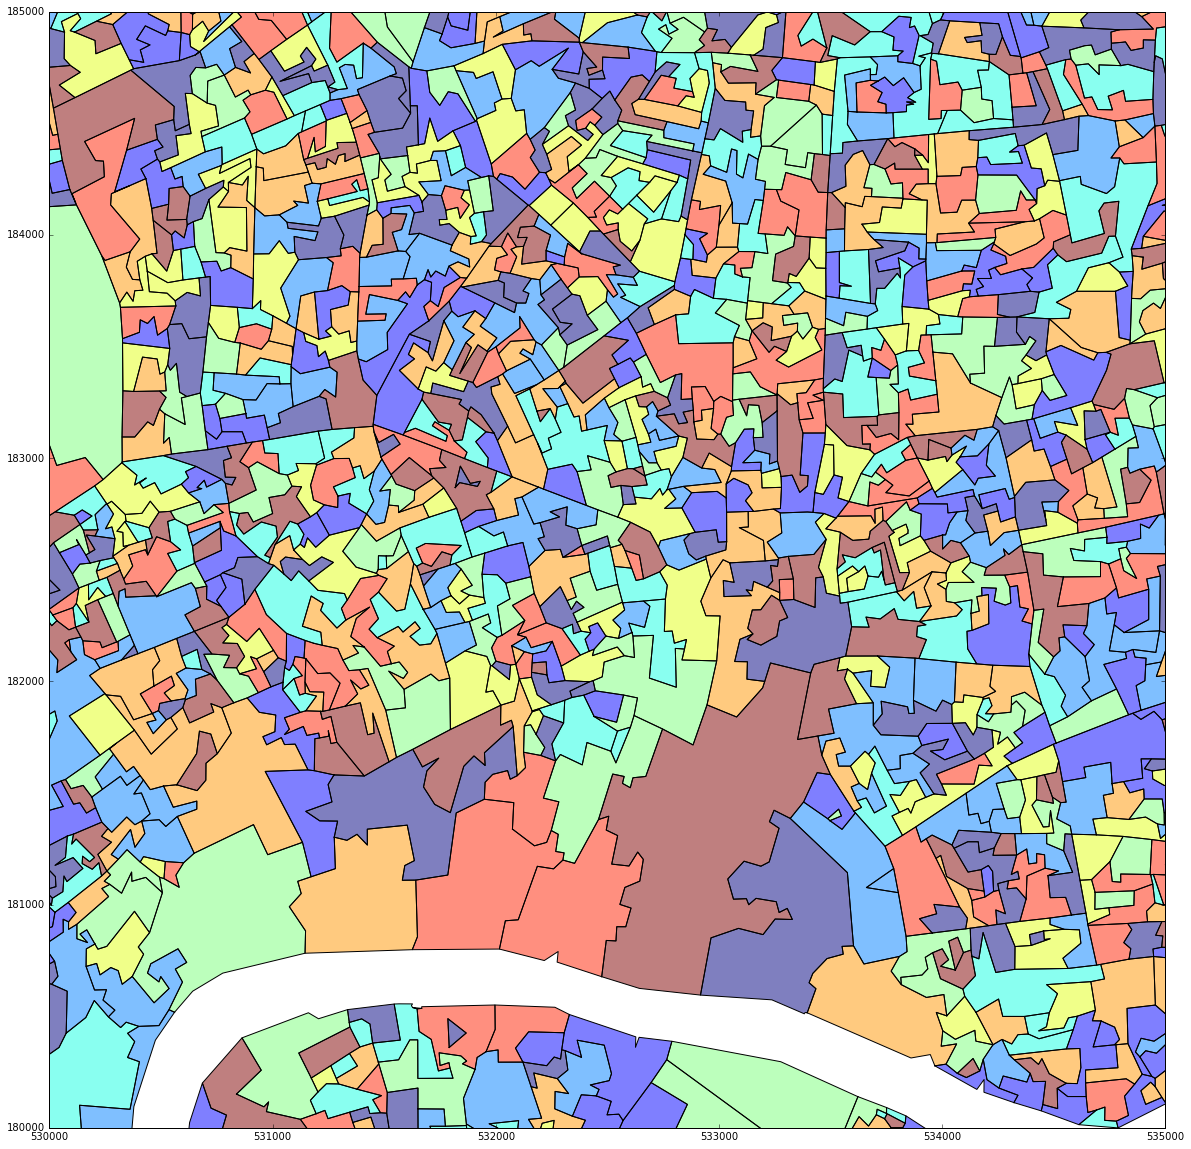

In [20]:
# Now, zoom in to create a visualization of the output areas surrounding the Strand area in Central London.

ax = loac_map.plot(figsize=(30,20))
ax.set_xlim(530000,535000)
ax.set_ylim(180000,185000)



In [ ]:
# Save the above visualization to an output file

pylab.savefig("LOAC_ZoomedIn")   


In [ ]:
# Need this for geocoding

geocoder = Nominatim()

In [21]:
# Now read in the same LOAC shapefile containing the Supergroup label for each of the 25,000 output areas in Greater London
# using the fiona library

loac = fiona.open('Shapefiles/LOAC_London.shp', 'r')

In [81]:
# Need this for interpreting different coordinate systems

bng = pyproj.Proj(init='epsg:27700')
wgs84 = pyproj.Proj(init='epsg:4326')


In [614]:
# This assigns a Supergroup code from the LOAC dataset to each tube and rail station in the TfL database

counter = 0    

while (counter < len(stationdic_df)):
    try:
        station_of_entry = geocoder.geocode(stationdic_df['STATIONNAME'][counter])
        x1, y1 = pyproj.transform(wgs84,bng,station_of_entry.longitude,station_of_entry.latitude)
        station_of_entry_pnt = Point(x1,y1)
        q1 = [w for w in loac if station_of_entry_pnt.within(shape(w["geometry"]))]
        if len(q1) != 0:
            stationdic_df['Supergroup'][counter] = q1[0]["properties"]['supgrp_cd']
    except GeocoderTimedOut as e:
        print ("Error: geocode failed on input %s with message %s" %(stationdic_df['STATIONNAME'][counter], e.msg))
    counter = counter + 1



C:\Users\HP-PC\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [615]:
# Check to see whether the stations were assigned a Supergroup label

stationdic_df

,STATIONKEY,STATIONNAME,Keep,Supergroup
0,1,"Acton Town Station, England",True,B
1,2,"Barbican Station, England",True,F
2,3,"Aldgate Station, England",True,D
3,4,"Aldgate East Station, England",True,D
4,5,"Alperton Station, England",True,C
5,6,"Amersham Station, England",True,0
6,7,"Angel Station, England",True,D
7,8,"Archway Station, England",True,E
8,9,"Arnos Grove Station, England",True,G
9,10,"Arsenal Station, England",True,E


In [616]:
# Save the new stationdic_df with the assigned Supergroup codes to a new output file

stationdic_df.to_csv("StationswithLOACcode_CK1.csv", sep = '\t')